In [42]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_market_calendars as mcal
from datetime import datetime

from toraniko import factor_math, model, styles

In [50]:
nyse = mcal.get_calendar('NYSE')
start_date = '2020-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')
trading_days = nyse.valid_days(start_date=start_date, end_date=end_date)

# Convert trading days to polars datetime
dates_df = pl.DataFrame({
    'date': trading_days
}).with_columns(
    pl.col('date').cast(pl.Datetime)
)
dates = dates_df['date']

# Create sample symbols (100 stocks)
symbols = [f'STOCK_{i}' for i in range(1, 101)]
num_symbols = len(symbols)
num_dates = len(dates)

# --- More Realistic Market Cap Generation ---
base_mkt_caps = np.random.lognormal(mean=np.log(1e9), sigma=1.5, size=num_symbols) # Base caps from ~1M to ~100B
mkt_cap_time_series = []
for base_cap in base_mkt_caps:
    daily_returns = np.random.normal(loc=0.0005, scale=0.02, size=num_dates) # Small daily drift + volatility
    cap_series = base_cap * np.cumprod(1 + daily_returns)
    mkt_cap_time_series.append(cap_series)

mkt_cap_data_list = []
for i, symbol in enumerate(symbols):
    for j, date_val in enumerate(dates):
        mkt_cap_data_list.append({
            'date': date_val,
            'symbol': symbol,
            'market_cap': mkt_cap_time_series[i][j]
        })
mkt_cap_df = pl.DataFrame(mkt_cap_data_list)

# --- More Realistic Value Metrics Generation ---
value_metrics_data_list = []
base_book_price = np.random.uniform(0.5, 3, size=num_symbols)
base_sales_price = np.random.uniform(0.2, 5, size=num_symbols)
base_cf_price = np.random.uniform(5, 20, size=num_symbols)

for i, symbol in enumerate(symbols):
    # Simulate some slow-moving changes for value metrics
    bp_series = base_book_price[i] * (1 + np.random.normal(0, 0.01, size=num_dates).cumsum() * 0.05)
    sp_series = base_sales_price[i] * (1 + np.random.normal(0, 0.01, size=num_dates).cumsum() * 0.05)
    cp_series = base_cf_price[i] * (1 + np.random.normal(0, 0.01, size=num_dates).cumsum() * 0.05)
    for j, date_val in enumerate(dates):
        value_metrics_data_list.append({
            'date': date_val,
            'symbol': symbol,
            'book_price': max(0.01, bp_series[j]), # Ensure positive
            'sales_price': max(0.01, sp_series[j]),
            'cf_price': max(0.01, cp_series[j])
        })
value_df = pl.DataFrame(value_metrics_data_list)

# Create sample returns data (can keep this simpler for now)
returns_data = {
    'date': np.repeat(dates, len(symbols)),
    'symbol': np.tile(symbols, len(dates)),
    'asset_returns': np.random.normal(0.0001, 0.02, len(dates) * len(symbols))
}
returns_df = pl.DataFrame(returns_data)

# Create sample sector data (remains relatively static)
sectors = ['TECH', 'FIN', 'HEALTH']
sector_assignments = np.random.choice(sectors, size=num_symbols)
sector_data_list = []
for i, symbol in enumerate(symbols):
    for date_val in dates:
        row = {'date': date_val, 'symbol': symbol}
        for sector in sectors:
            row[sector] = 1 if sector_assignments[i] == sector else 0
        sector_data_list.append(row)
sector_df = pl.DataFrame(sector_data_list)

print(f"Date range for initial data generation: {dates[0]} to {dates[-1]}")
print(f"Number of trading days: {len(dates)}")
print("\nReturns DataFrame:")
print(returns_df.head())
print("\nMarket Cap DataFrame:")
print(mkt_cap_df.head())
print("\nSector DataFrame:")
print(sector_df.head())
print("\nValue Metrics DataFrame:")
print(value_df.head())

Date range for initial data generation: 2020-01-02 00:00:00 to 2025-05-16 00:00:00
Number of trading days: 1351

Returns DataFrame:
shape: (5, 3)
┌─────────────────────┬─────────┬───────────────┐
│ date                ┆ symbol  ┆ asset_returns │
│ ---                 ┆ ---     ┆ ---           │
│ datetime[μs]        ┆ str     ┆ f64           │
╞═════════════════════╪═════════╪═══════════════╡
│ 2020-01-02 00:00:00 ┆ STOCK_1 ┆ -0.002208     │
│ 2020-01-02 00:00:00 ┆ STOCK_2 ┆ 0.01848       │
│ 2020-01-02 00:00:00 ┆ STOCK_3 ┆ -0.02815      │
│ 2020-01-02 00:00:00 ┆ STOCK_4 ┆ -0.00552      │
│ 2020-01-02 00:00:00 ┆ STOCK_5 ┆ 0.025624      │
└─────────────────────┴─────────┴───────────────┘

Market Cap DataFrame:
shape: (5, 3)
┌─────────────────────┬─────────┬────────────┐
│ date                ┆ symbol  ┆ market_cap │
│ ---                 ┆ ---     ┆ ---        │
│ datetime[μs]        ┆ str     ┆ f64        │
╞═════════════════════╪═════════╪════════════╡
│ 2020-01-02 00:00:00 ┆ STOCK_1 

In [111]:
returns_df = pl.read_parquet("../data/returns_df.parquet")
mkt_cap_df = pl.read_parquet("../data/mkt_cap_df.parquet")
sector_df = pl.read_parquet("../data/sector_df.parquet")
value_df = pl.read_parquet("../data/value_df.parquet")
def to_us(df: pl.LazyFrame) -> pl.LazyFrame:
    return df.with_columns(
        pl.col("date").dt.cast_time_unit("us")        # use .with_time_unit("us") if < 0.19
    )

returns_df = to_us(returns_df)
mkt_cap_df = to_us(mkt_cap_df)
sector_df = to_us(sector_df)
value_df = to_us(value_df)

In [112]:
mom_df = styles.factor_mom(
    returns_df=returns_df,
    trailing_days=252,  # ~2 years of trading days
    half_life=126,     # ~6 months decay
    lag=20,            # 1 month lag
    winsor_factor=0.01
).collect()

# Construct size factor
sze_df = styles.factor_sze(
    mkt_cap_df=mkt_cap_df,
    lower_decile=0.2,  # Exclude smallest 20%
    upper_decile=0.8   # Exclude largest 20%
).collect()

# Construct value factor
val_df = styles.factor_val(
    value_df=value_df,
    winsorize_features=0.01  # Winsorize value metrics at 1%
).collect()
val_df = val_df.fill_nan(0.0)


# Combine style factors
style_df = (
    mom_df.join(sze_df, on=['date', 'symbol'])
    .join(val_df, on=['date', 'symbol'])
    .rename({
        'mom_score': 'MOMENTUM',
        'sze_score': 'SIZE',
        'val_score': 'VALUE'
    })
)

print("Style factors after construction:")
print(style_df.head())

Style factors after construction:
shape: (5, 5)
┌─────────────────────┬────────┬──────────┬──────┬───────────┐
│ date                ┆ symbol ┆ MOMENTUM ┆ SIZE ┆ VALUE     │
│ ---                 ┆ ---    ┆ ---      ┆ ---  ┆ ---       │
│ datetime[μs]        ┆ str    ┆ f64      ┆ f64  ┆ f64       │
╞═════════════════════╪════════╪══════════╪══════╪═══════════╡
│ 2024-02-01 00:00:00 ┆ A      ┆ null     ┆ 0.0  ┆ -0.417547 │
│ 2024-02-02 00:00:00 ┆ A      ┆ null     ┆ 0.0  ┆ -0.4146   │
│ 2024-02-05 00:00:00 ┆ A      ┆ null     ┆ 0.0  ┆ -0.418983 │
│ 2024-02-06 00:00:00 ┆ A      ┆ null     ┆ 0.0  ┆ -0.432497 │
│ 2024-02-07 00:00:00 ┆ A      ┆ null     ┆ 0.0  ┆ -0.412281 │
└─────────────────────┴────────┴──────────┴──────┴───────────┘


In [135]:
style_df = style_df.drop_nulls()

# 2. Find the minimum common start date
min_style_date = style_df['date'].min()
min_returns_date = returns_df['date'].min()
min_mkt_cap_date = mkt_cap_df['date'].min()
min_sector_date = sector_df['date'].min()
common_start_date = max(min_style_date, min_returns_date, min_mkt_cap_date, min_sector_date)

print(f"Common start date after aligning for momentum: {common_start_date}")

# 3. Filter all DataFrames to the common start date
style_df = style_df.filter(pl.col('date') >= common_start_date)
returns_df = returns_df.filter(pl.col('date') >= common_start_date)
mkt_cap_df = mkt_cap_df.filter(pl.col('date') >= common_start_date)
sector_df = sector_df.filter(pl.col('date') >= common_start_date)

print("Shape of style_df after alignment: ", style_df.shape)
print("Shape of returns_df after alignment: ", returns_df.shape)
print("Shape of mkt_cap_df after alignment: ", mkt_cap_df.shape)
print("Shape of sector_df after alignment: ", sector_df.shape)

Common start date after aligning for momentum: 2024-12-02 00:00:00
Shape of style_df after alignment:  (57228, 5)
Shape of returns_df after alignment:  (57228, 3)
Shape of mkt_cap_df after alignment:  (57228, 3)
Shape of sector_df after alignment:  (57228, 13)


In [136]:
style_df = (
    style_df
        .fill_null(0)        # fixes real nulls
        .fill_nan(0.0)       # fixes NaNs in float columns
)

In [137]:
style_df.describe()

shape: (9, 6)
┌────────────┬────────────────────────────┬────────┬────────────┬───────────┬─────────────┐
│ statistic  ┆ date                       ┆ symbol ┆ MOMENTUM   ┆ SIZE      ┆ VALUE       │
│ ---        ┆ ---                        ┆ ---    ┆ ---        ┆ ---       ┆ ---         │
│ str        ┆ str                        ┆ str    ┆ f64        ┆ f64       ┆ f64         │
╞════════════╪════════════════════════════╪════════╪════════════╪═══════════╪═════════════╡
│ count      ┆ 57228                      ┆ 57228  ┆ 57228.0    ┆ 57228.0   ┆ 57228.0     │
│ null_count ┆ 0                          ┆ 0      ┆ 0.0        ┆ 0.0       ┆ 0.0         │
│ mean       ┆ 2025-02-23 17:41:03.157894 ┆ null   ┆ 4.4573e-17 ┆ -0.069376 ┆ -2.6198e-17 │
│ std        ┆ null                       ┆ null   ┆ 0.996227   ┆ 0.930883  ┆ 0.968721    │
│ min        ┆ 2024-12-02 00:00:00        ┆ A      ┆ -2.789918  ┆ -4.121956 ┆ -2.308283   │
│ 25%        ┆ 2025-01-14 00:00:00        ┆ null   ┆ -0.653661  ┆ 0.0       ┆ -0.661606   │
│ 50%        ┆ 2025-02-26 00:00:00        ┆ null   ┆ -0.048057  ┆ 0.0       ┆ -0.054908   │
│ 75%        ┆ 2025-04-07 00:00:00        ┆ null   ┆ 0.574367   ┆ 0.0       ┆ 0.492009    │
│ max        ┆ 2025-05-16 00:00:00        ┆ ZTS    ┆ 4.177457   ┆ 1.893426  ┆ 2.619812    │
└────────────┴────────────────────────────┴────────┴────────────┴───────────┴─────────────┘

In [133]:
nan_cnt = style_df.select(
    [pl.col(c).is_nan().sum().alias(c) for c in style_df.columns if style_df[c].dtype.is_float()]
)
nan_in_mom = style_df.filter(pl.col("MOMENTUM").is_nan())
nan_in_mom

shape: (318, 5)
┌─────────────────────┬────────┬──────────┬──────┬───────────┐
│ date                ┆ symbol ┆ MOMENTUM ┆ SIZE ┆ VALUE     │
│ ---                 ┆ ---    ┆ ---      ┆ ---  ┆ ---       │
│ datetime[μs]        ┆ str    ┆ f64      ┆ f64  ┆ f64       │
╞═════════════════════╪════════╪══════════╪══════╪═══════════╡
│ 2024-12-02 00:00:00 ┆ GEV    ┆ NaN      ┆ 0.0  ┆ -0.46127  │
│ 2024-12-03 00:00:00 ┆ GEV    ┆ NaN      ┆ 0.0  ┆ -0.453869 │
│ 2024-12-04 00:00:00 ┆ GEV    ┆ NaN      ┆ 0.0  ┆ -0.474268 │
│ 2024-12-05 00:00:00 ┆ GEV    ┆ NaN      ┆ 0.0  ┆ -0.485904 │
│ 2024-12-06 00:00:00 ┆ GEV    ┆ NaN      ┆ 0.0  ┆ -0.482859 │
│ …                   ┆ …      ┆ …        ┆ …    ┆ …         │
│ 2025-05-12 00:00:00 ┆ SW     ┆ NaN      ┆ 0.0  ┆ 0.72685   │
│ 2025-05-13 00:00:00 ┆ SW     ┆ NaN      ┆ 0.0  ┆ 0.709661  │
│ 2025-05-14 00:00:00 ┆ SW     ┆ NaN      ┆ 0.0  ┆ 0.697172  │
│ 2025-05-15 00:00:00 ┆ SW     ┆ NaN      ┆ 0.0  ┆ 0.701578  │
│ 2025-05-16 00:00:00 ┆ SW     ┆ NaN      ┆ 0.0  ┆ 0.708635  │
└─────────────────────┴────────┴──────────┴──────┴───────────┘

In [138]:
factor_returns, residual_returns = model.estimate_factor_returns(
    returns_df=returns_df,
    mkt_cap_df=mkt_cap_df,
    sector_df=sector_df,
    style_df=style_df,
    winsor_factor=None,  # Factors are already properly processed
    residualize_styles=True
)

print("Factor Returns DataFrame:")
print(factor_returns.head())
print("\nResidual Returns DataFrame:")
print(residual_returns.head())

Factor Returns DataFrame:
shape: (5, 16)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ market    ┆ Basic     ┆ Communica ┆ Consumer  ┆ … ┆ MOMENTUM  ┆ SIZE      ┆ VALUE     ┆ date     │
│ ---       ┆ Materials ┆ tion      ┆ Cyclical  ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ f64       ┆ ---       ┆ Services  ┆ ---       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ datetime │
│           ┆ f64       ┆ ---       ┆ f64       ┆   ┆           ┆           ┆           ┆ [μs]     │
│           ┆           ┆ f64       ┆           ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ -0.003592 ┆ 0.003887  ┆ 0.009751  ┆ 0.01002   ┆ … ┆ -0.004717 ┆ -0.001723 ┆ -0.000884 ┆ 2024-12- │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 02       │
│           ┆           ┆           ┆           ┆ 

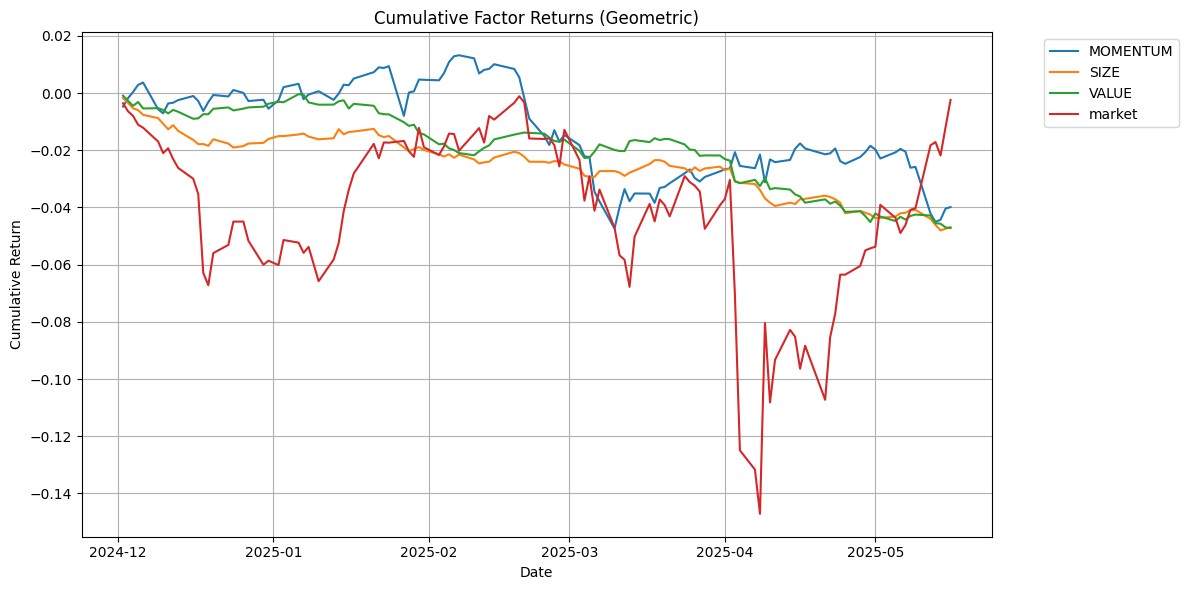

In [143]:
#factor_return_cols = [col for col in factor_returns.columns if col != 'date']
factor_return_cols = ['MOMENTUM','SIZE','VALUE',"market"]

# Expressions for geometric cumulative returns
cumulative_returns_exprs = []
for col_name in factor_return_cols:
    cumulative_returns_exprs.append(
        ((pl.col(col_name) + 1).cum_prod() - 1).alias(col_name) # Keep original name for simplicity
    )

cumulative_returns_df = factor_returns.select(
    [pl.col('date')] + cumulative_returns_exprs
)

# Plot cumulative factor returns
plt.figure(figsize=(12, 6))
for col_name in factor_return_cols: # Iterate through original factor names
    plt.plot(cumulative_returns_df['date'], cumulative_returns_df[col_name], label=col_name)
plt.title('Cumulative Factor Returns (Geometric)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [144]:
stats_exprs = []
for col_name in factor_return_cols:
    stats_exprs.append(pl.col(col_name).mean().alias(f"{col_name}_mean"))
    stats_exprs.append(pl.col(col_name).std().alias(f"{col_name}_std"))
    stats_exprs.append(pl.col(col_name).skew().alias(f"{col_name}_skew"))
    stats_exprs.append(pl.col(col_name).kurtosis().alias(f"{col_name}_kurtosis"))

factor_stats = factor_returns.select(stats_exprs)

print("\nFactor Return Statistics (Wide Format):")
print(factor_stats)


Factor Return Statistics (Wide Format):
shape: (1, 16)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ MOMENTUM_ ┆ MOMENTUM_ ┆ MOMENTUM_ ┆ MOMENTUM_ ┆ … ┆ market_me ┆ market_st ┆ market_sk ┆ market_k │
│ mean      ┆ std       ┆ skew      ┆ kurtosis  ┆   ┆ an        ┆ d         ┆ ew        ┆ urtosis  │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ -0.000347 ┆ 0.004329  ┆ -1.241982 ┆ 2.920079  ┆ … ┆ 0.00007   ┆ 0.013569  ┆ 0.653747  ┆ 11.58894 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 8        │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘


In [145]:
sample_stocks = symbols[:5]  # Look at first 5 stocks
residual_stats_exprs = []
for stock_symbol in sample_stocks:
    residual_stats_exprs.append(pl.col(stock_symbol).mean().alias(f"{stock_symbol}_mean"))
    residual_stats_exprs.append(pl.col(stock_symbol).std().alias(f"{stock_symbol}_std"))
    residual_stats_exprs.append(pl.col(stock_symbol).skew().alias(f"{stock_symbol}_skew"))
    residual_stats_exprs.append(pl.col(stock_symbol).kurtosis().alias(f"{stock_symbol}_kurtosis"))

residual_stats = residual_returns.select(residual_stats_exprs)

print("Residual Statistics for Sample Stocks (Wide Format):")
print(residual_stats)

# Plot residual return distribution for a sample stock
if sample_stocks and sample_stocks[0] in residual_returns.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(residual_returns[sample_stocks[0]], kde=True, stat="density", common_norm=False)
    plt.title(f'Residual Return Distribution for {sample_stocks[0]}')
    plt.xlabel('Residual Return')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()
else:
    print(f"Could not plot residual distribution: {sample_stocks[0] if sample_stocks else 'No sample stock'} not in residual_returns columns or no sample stocks.")

ColumnNotFoundError: STOCK_1